In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import obspy.taup
import obspy.taup.taup_create

%matplotlib inline 

In [2]:
import earth_model

## Tabulate the model

Because we have to

In [3]:
prem = earth_model.Prem()
# Get a table of PREM values every 10 km going inwards
# and dealing with the discontiuities 
table = prem.tabulate_model_inwards(20)
# Print the firs few depths
# note the discontiuities
print(np.record.pprint(table[0:7]))


  depth: [ 0.  15.  15.  24.4 24.4 44.4 64.4]
 radius: [6371.  6356.  6356.  6346.6 6346.6 6326.6 6306.6]
density: [2600.         2600.         2900.         2900.         3380.74820907
 3378.57460995 3376.40101083]
     vp: [5.8        5.8        6.8        6.8        8.11061727 8.09825437
 8.08589148]
     vs: [3.2        3.2        3.9        3.9        4.49100712 4.48363591
 4.47626469]
 qkappa: [57823. 57823. 57823. 57823. 57823. 57823. 57823.]
 qshear: [600. 600. 600. 600. 600. 600. 600.]


## Build an Obspy `TauPyModel`

And clean up the mess

In [4]:
model_name = 'model'
tvel_filename = model_name + '.tvel'
taup_filename = model_name + '.npz'
f = open(tvel_filename, 'w')
f.write("P name\n")
f.write("S name\n")
for d, vp, vs, rho in zip(table.depth, table.vp, table.vs, table.density):
    f.write("{:10.3f} {:10.4f} {:10.4f} {:10.4f}\n".format(d, vp, vs, rho/1000.0))

f.close()

In [5]:
# Look at the top of the tvel file (just to see what it looks like)
!head "$tvel_filename"

P name
S name
     0.000     5.8000     3.2000     2.6000
    15.000     5.8000     3.2000     2.6000
    15.000     6.8000     3.9000     2.9000
    24.400     6.8000     3.9000     2.9000
    24.400     8.1106     4.4910     3.3807
    44.400     8.0983     4.4836     3.3786
    64.400     8.0859     4.4763     3.3764
    80.000     8.0762     4.4705     3.3747


In [6]:
# Build a taup model and store it in a numpy compressed file
obspy.taup.taup_create.build_taup_model(tvel_filename, output_folder='.', verbose=True)

Building obspy.taup model for 'model.tvel' ...
filename = model.tvel
Done reading velocity model.
Radius of model  is 6371.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  891 P layers,940 S layers
Done calculating Tau branches.
Done Saving ./model.npz
Method run is done, but not necessarily successful.


In [7]:
taup = obspy.taup.tau.TauPyModel('./'+taup_filename)

In [8]:
# Clean up at the end (don't want to keep these file)
os.remove(tvel_filename)
os.remove(taup_filename)

## Create plot of raypaths and travel times

This now becomes easy

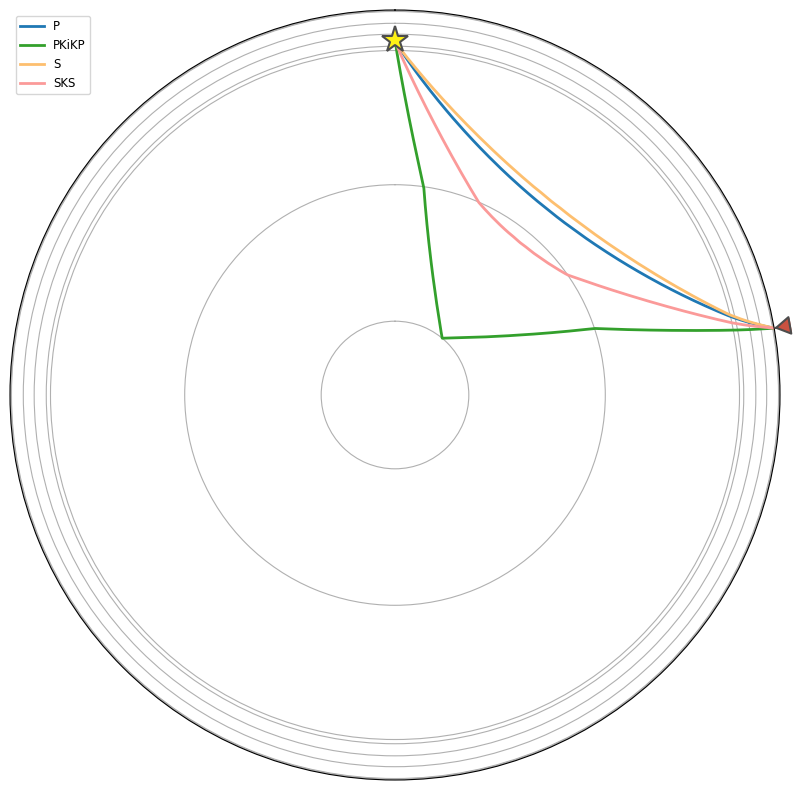

In [9]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection':'polar'})

arrivals = taup.get_ray_paths(source_depth_in_km=500,
                               distance_in_degree=80,
                               phase_list=["P", "S", "PKP", 
                                           "PKIKP", "PKiKP",
                                           "S", "SKS"])

ax = arrivals.plot_rays(fig=fig, ax=ax, legend=True)

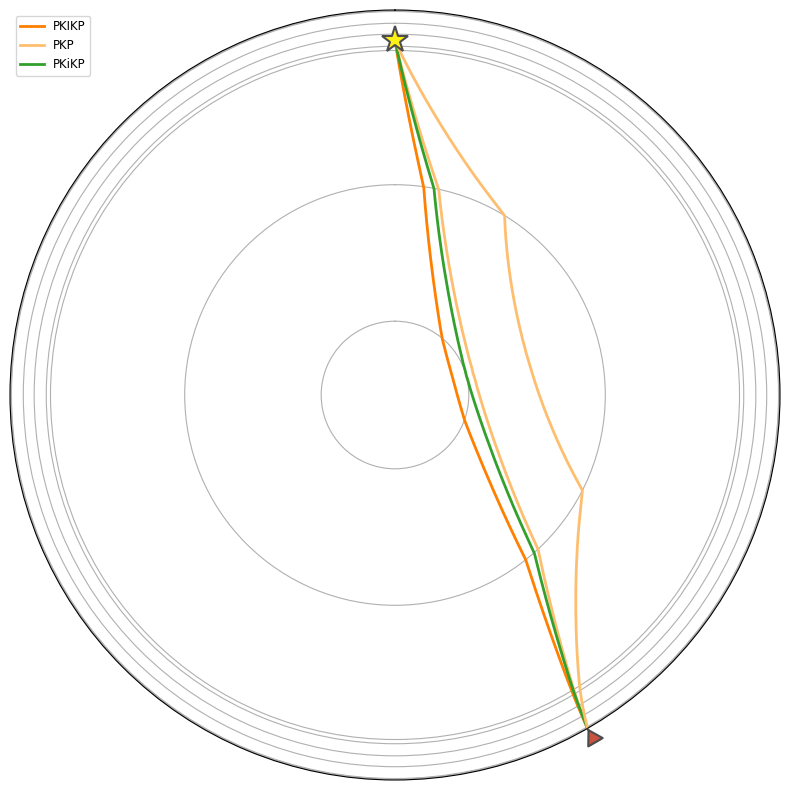

In [10]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection':'polar'})

arrivals = taup.get_ray_paths(source_depth_in_km=500,
                               distance_in_degree=150,
                               phase_list=["P", "S", "PKP", 
                                           "PKIKP", "PKiKP",
                                           "S", "SKS"])

ax = arrivals.plot_rays(fig=fig, ax=ax, legend=True)

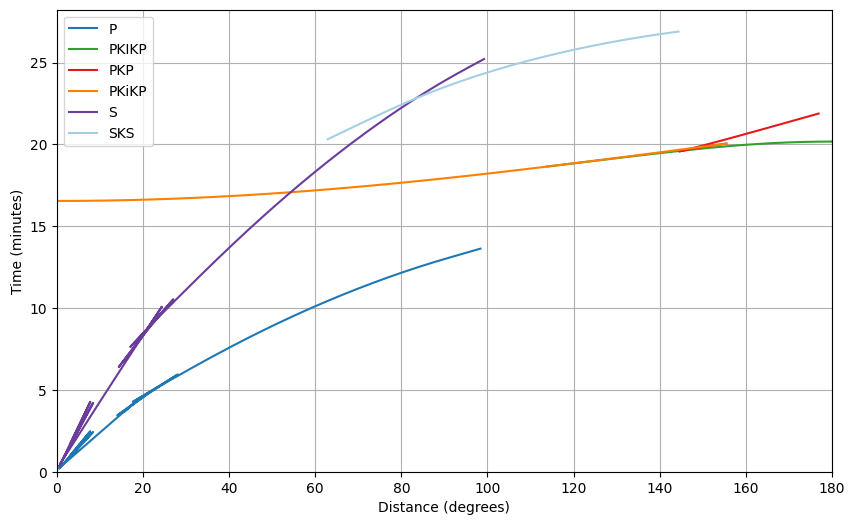

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = obspy.taup.plot_travel_times(source_depth=10, phase_list=["P", "S", "PKP", 
                                                               "PKIKP", "PKiKP",
                                                               "S", "SKS"],
                       ax=ax, fig=fig, verbose=True, show=False)


plt.show()

In [12]:
# NB - extracted from table VId
p_dists = np.array([23.0, 31.0, 41.0, 51.0, 61.0, 71.0, 81.0, 91.0])
p_times = np.array([263.57, 332.83, 415.35, 490.78, 559.81, 621.73, 676.86, 724.39])
p_error = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

There were 8 epicentral distances without an arrival


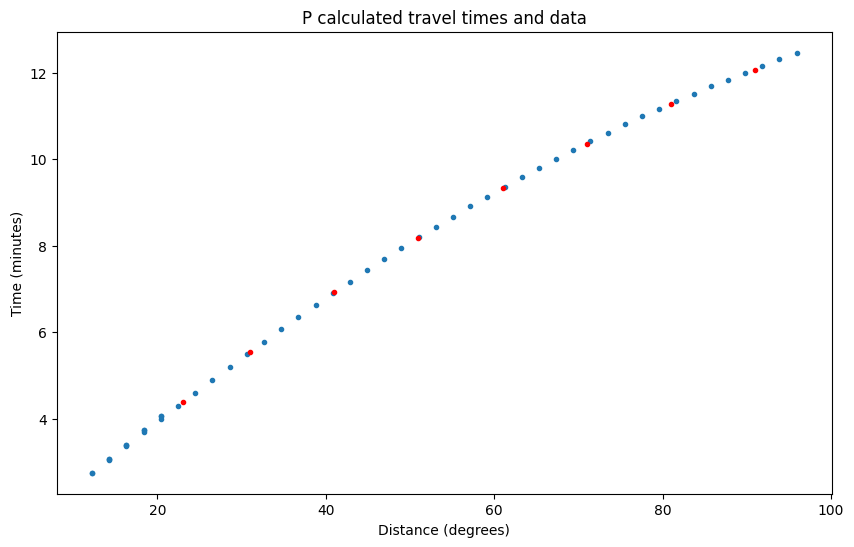

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = obspy.taup.plot_travel_times(source_depth=550, phase_list=["P"],
                       ax=ax, fig=fig, verbose=True, show=False, legend=False,
                        max_degrees=100, npoints=50)

ax.errorbar(p_dists, p_times/60, yerr=p_error/60, fmt='r.')
ax.set_title("P calculated travel times and data")
plt.show()

In [14]:
# NB - I've added 100 degrees to all PKP distances
#      I've a feeling this is a typo in table VIf...
pkp_dists = np.array([146.00, 148.00, 150.00, 152.00])
pkp_times = np.array([1180.50, 1186.11, 1191.25, 1195.87])
pkp_error = np.array([0.3, 0.3, 0.3, 0.3])

There were 472 epicentral distances without an arrival


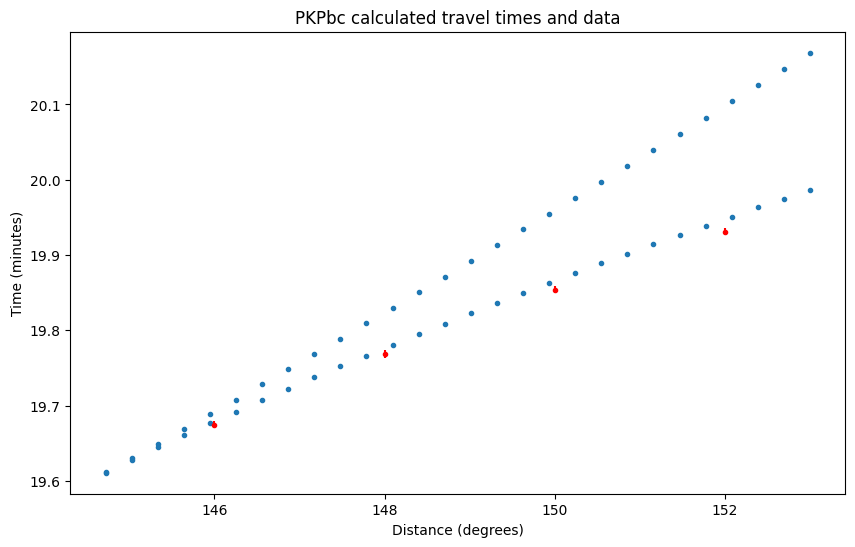

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = obspy.taup.plot_travel_times(source_depth=0, phase_list=["PKP"],
                       ax=ax, fig=fig, verbose=True, show=False, legend=False,
                        max_degrees=153, npoints=500)

ax.errorbar(pkp_dists, pkp_times/60, yerr=pkp_error/60, fmt='r.')
ax.set_title("PKPbc calculated travel times and data")
plt.show()